# Reconstruction - **Lane**

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

Load the CSV File and Extract Points

In [2]:
# Define the CSV file path
PROJECT_ROOT = Path().resolve().parent.parent
CSV_POSITIONS_FILE_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "lane_points" / "lane_points_processed_2.csv")
VIDEO_PATH = str(PROJECT_ROOT / "data" / "recording_2" / "Recording_2.mp4")

# Load video and extract frame
cap = cv2.VideoCapture(str(VIDEO_PATH))
frame_number = 199
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

# Load the CSV file
df = pd.read_csv(CSV_POSITIONS_FILE_PATH)
row = df[df['Frame'] == frame_number]

if row.empty:
    raise ValueError(f"No data found for frame {frame_number}")

# Extract the coordinates
pts_src = np.array([
    [row['bottom_left_x'].values[0], row['bottom_left_y'].values[0]],
    [row['bottom_right_x'].values[0], row['bottom_right_y'].values[0]],
    [row['up_left_x'].values[0], row['up_left_y'].values[0]],
    [row['up_right_x'].values[0], row['up_right_y'].values[0]]
], dtype=np.int32)

print("Source points:\n", pts_src)

Source points:
 [[ 578  927]
 [1509  943]
 [ 999  467]
 [1364  469]]


In [3]:
# Function to display an image
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

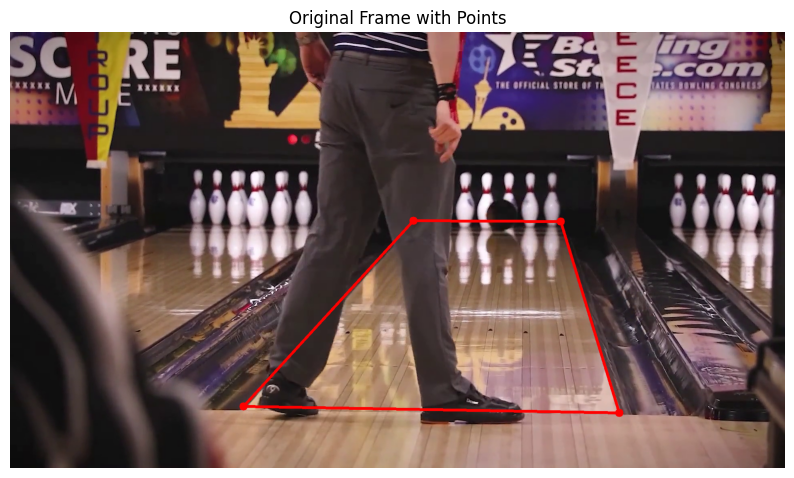

In [4]:
# Draw the points on the frame
for point in pts_src:
    cv2.circle(frame, tuple(point), radius=10, color=(0, 0, 255), thickness=-1)

# Draw lines connecting the points to form a parallelepiped
if len(pts_src) == 4:
    edges = [(0, 1), (1, 3), (3, 2), (2, 0)]
    
    for edge in edges:
        pt1 = tuple(pts_src[edge[0]])
        pt2 = tuple(pts_src[edge[1]])
        cv2.line(frame, pt1, pt2, (0, 0, 255), 6)

showImage(frame, "Original Frame with Points")

Define the Real-World Dimensions

In [5]:
# Width and height in pixels
width = 1066    # Approximate pixels for 1.0668m
height = 18290  # Approximate pixels for 18.29m

# Define destination points
pts_dst = np.array([
    [0, height],      # Bottom-left
    [width, height],  # Bottom-right
    [0, 0],           # Top-left
    [width, 0]        # Top-right
], dtype=np.float32)

print("Destination points:\n", pts_dst)

Destination points:
 [[    0. 18290.]
 [ 1066. 18290.]
 [    0.     0.]
 [ 1066.     0.]]


Compute the Homography

In [6]:
# Compute homography matrix
H, _ = cv2.findHomography(pts_src, pts_dst)
print("Homography matrix:\n", H)

Homography matrix:
 [[-5.10460086e+00 -4.67181948e+00  7.28123595e+03]
 [ 9.59031976e-01 -1.75023336e+02  8.07778248e+04]
 [-1.15904555e-05 -5.84387794e-03  1.00000000e+00]]


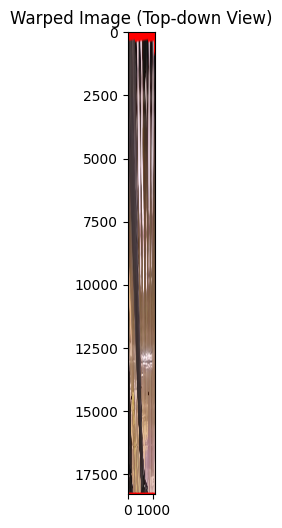

In [7]:
# Warp the perspective
warped_frame = cv2.warpPerspective(frame, H, (width, height))

# Display the result
plt.figure(figsize=(10, 6)) 
plt.imshow(cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB))
plt.title("Warped Image (Top-down View)")
#plt.axis("off")
plt.show()

# Recostruction - **Ball**

In [ ]:
# Define the path to the CSV file
CSV_POINTS_POSITIONS_FILE_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / "Circle_positions_processed_2.csv")

# Load the CSV file and find the coordinates I want
df = pd.read_csv(CSV_POINTS_POSITIONS_FILE_PATH)
frame_100_row = df[df['frame'] == frame_number]

# Check
if not frame_100_row.empty:
    x = frame_100_row['x'].values[0]
    y = frame_100_row['y'].values[0]
    r = frame_100_row['radius'].values[0]
    print(f"Coordinates at Frame {frame_number}: X = {x}, Y = {y} \nRadius at Frame {frame_number}: r = {r}")
else:
    print(f"Frame {frame_number} not found in the CSV file.")

Coordinates at Frame 199: X = 1219.0, Y = 454.0 
Radius at Frame 199: r = 39.0


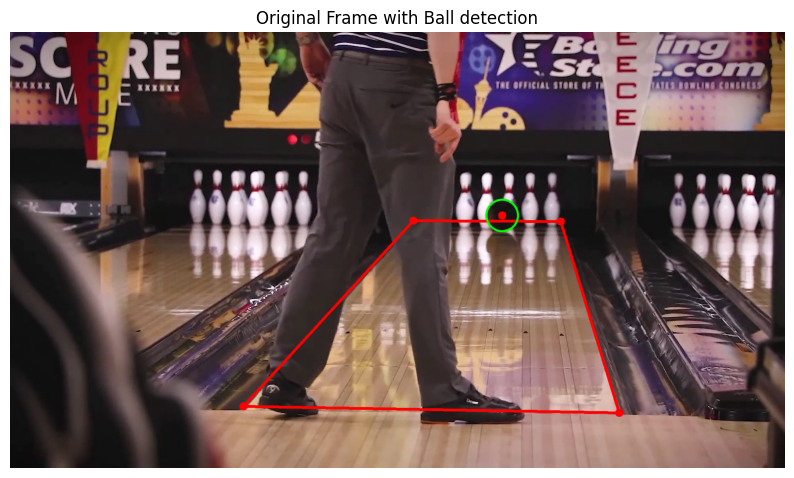

In [9]:
cv2.circle(frame, (int(x), int(y)), radius=10, color=(0, 0, 255), thickness=-1) # Center
cv2.circle(frame, (int(x), int(y)), radius=int(r), color=(0, 255, 0), thickness=3)   # Circle

showImage(frame, "Original Frame with Ball detection")

I want to take the meeting point between the lane and the ball

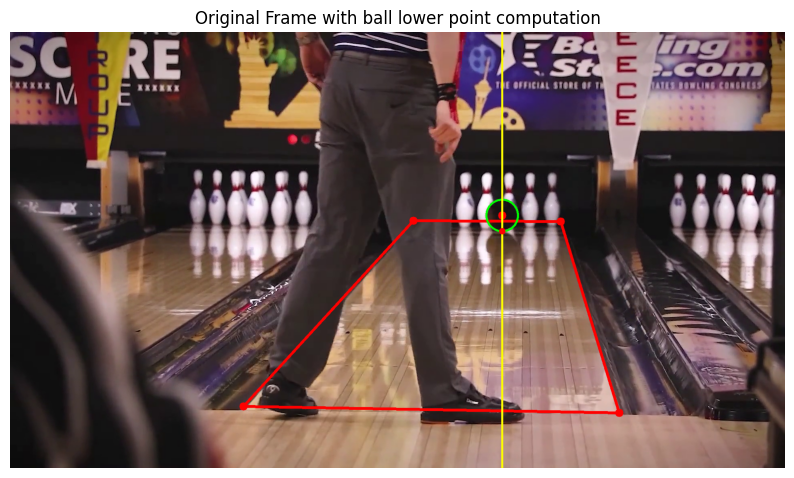

In [10]:
# Draw the vertical line passing through the center
cv2.line(frame, (int(x), 0), (int(x), frame.shape[0]), (0, 255, 255), 3)

# Compute the lower intersection point
lower_intersection = np.array([[int(x), int(y + r)]], dtype=np.float32)

# Draw the lower intersection point
cv2.circle(frame, (int(lower_intersection[0][0]), int(lower_intersection[0][1])), radius=8, color=(0, 0, 255), thickness=-1)

showImage(frame, "Original Frame with ball lower point computation")

Now I apply the homography to the point of contact between the ball and the ground

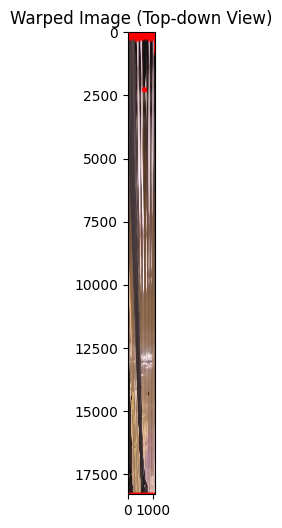

In [11]:
# Apply homography transformation
transformed_point = cv2.perspectiveTransform(np.array([lower_intersection]), H)[0][0]

# Draw the transformed point in the reconstructed image
cv2.circle(warped_frame, (int(transformed_point[0]), int(transformed_point[1])), radius=108, color=(0, 0, 255), thickness=-1) # 108 = radius of the ball

# Display the result
plt.figure(figsize=(10, 6)) 
plt.imshow(cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB))
plt.title("Warped Image (Top-down View)")
#plt.axis("off")
plt.show()

### Using the representation of the alley

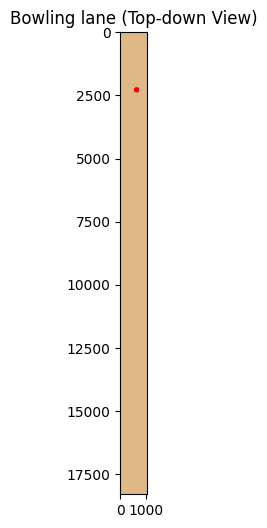

In [12]:
# Track image
brown_color = (135, 184, 222)  # RGB for burly wood
alley = np.full((height, width, 3), brown_color, dtype=np.uint8)

# Draw the transformed point in the reconstructed image
cv2.circle(alley, (int(transformed_point[0]), int(transformed_point[1])), radius=108, color=(0, 0, 255), thickness=-1) # 108 = radius of the ball

# Display the result
plt.figure(figsize=(10, 6)) 
plt.imshow(cv2.cvtColor(alley, cv2.COLOR_BGR2RGB))
plt.title("Bowling lane (Top-down View)")
#plt.axis("off")
plt.show()

IMPROVEMENTS: add another representation of the lane, maybe with other dimensions (see official videos on youtube)